In [118]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [119]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:
1. age — возраст основного бенефициара;
2. sex — пол страхового подрядчика;
3. bmi — индекс массы тела (кгм), в идеале — от 18.5 до 24.9;
4. children — количество детей, охваченных медицинской страховкой;
5. smoker — является ли человек курящим;
6. region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
7. charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [120]:
print(data.shape)
# (1338, 7)

(1338, 7)


In [121]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски отсутствуют

In [122]:
# посмотрим на типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Наши данные содержат несколько типов признаков:

age, bmi, children — числовые признаки;
sex, smoker — бинарные категориальные переменные (две категории);
region — множественные категориальные переменные (несколько категорий);
charges — числовой целевой признак.

Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

гистограммы/коробчатые диаграммы числовых признаков;
столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

Исследование данных

In [123]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [124]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Проведем небольшое исследование зависимости целевого признака price от числовых признаков.

In [125]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

In [126]:
# выделяем категориальные признаки
cat_features = list(types[(types == 'object')].index)
cat_features

['sex', 'smoker', 'region']

Для каждого числового признака построим гистограмму и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

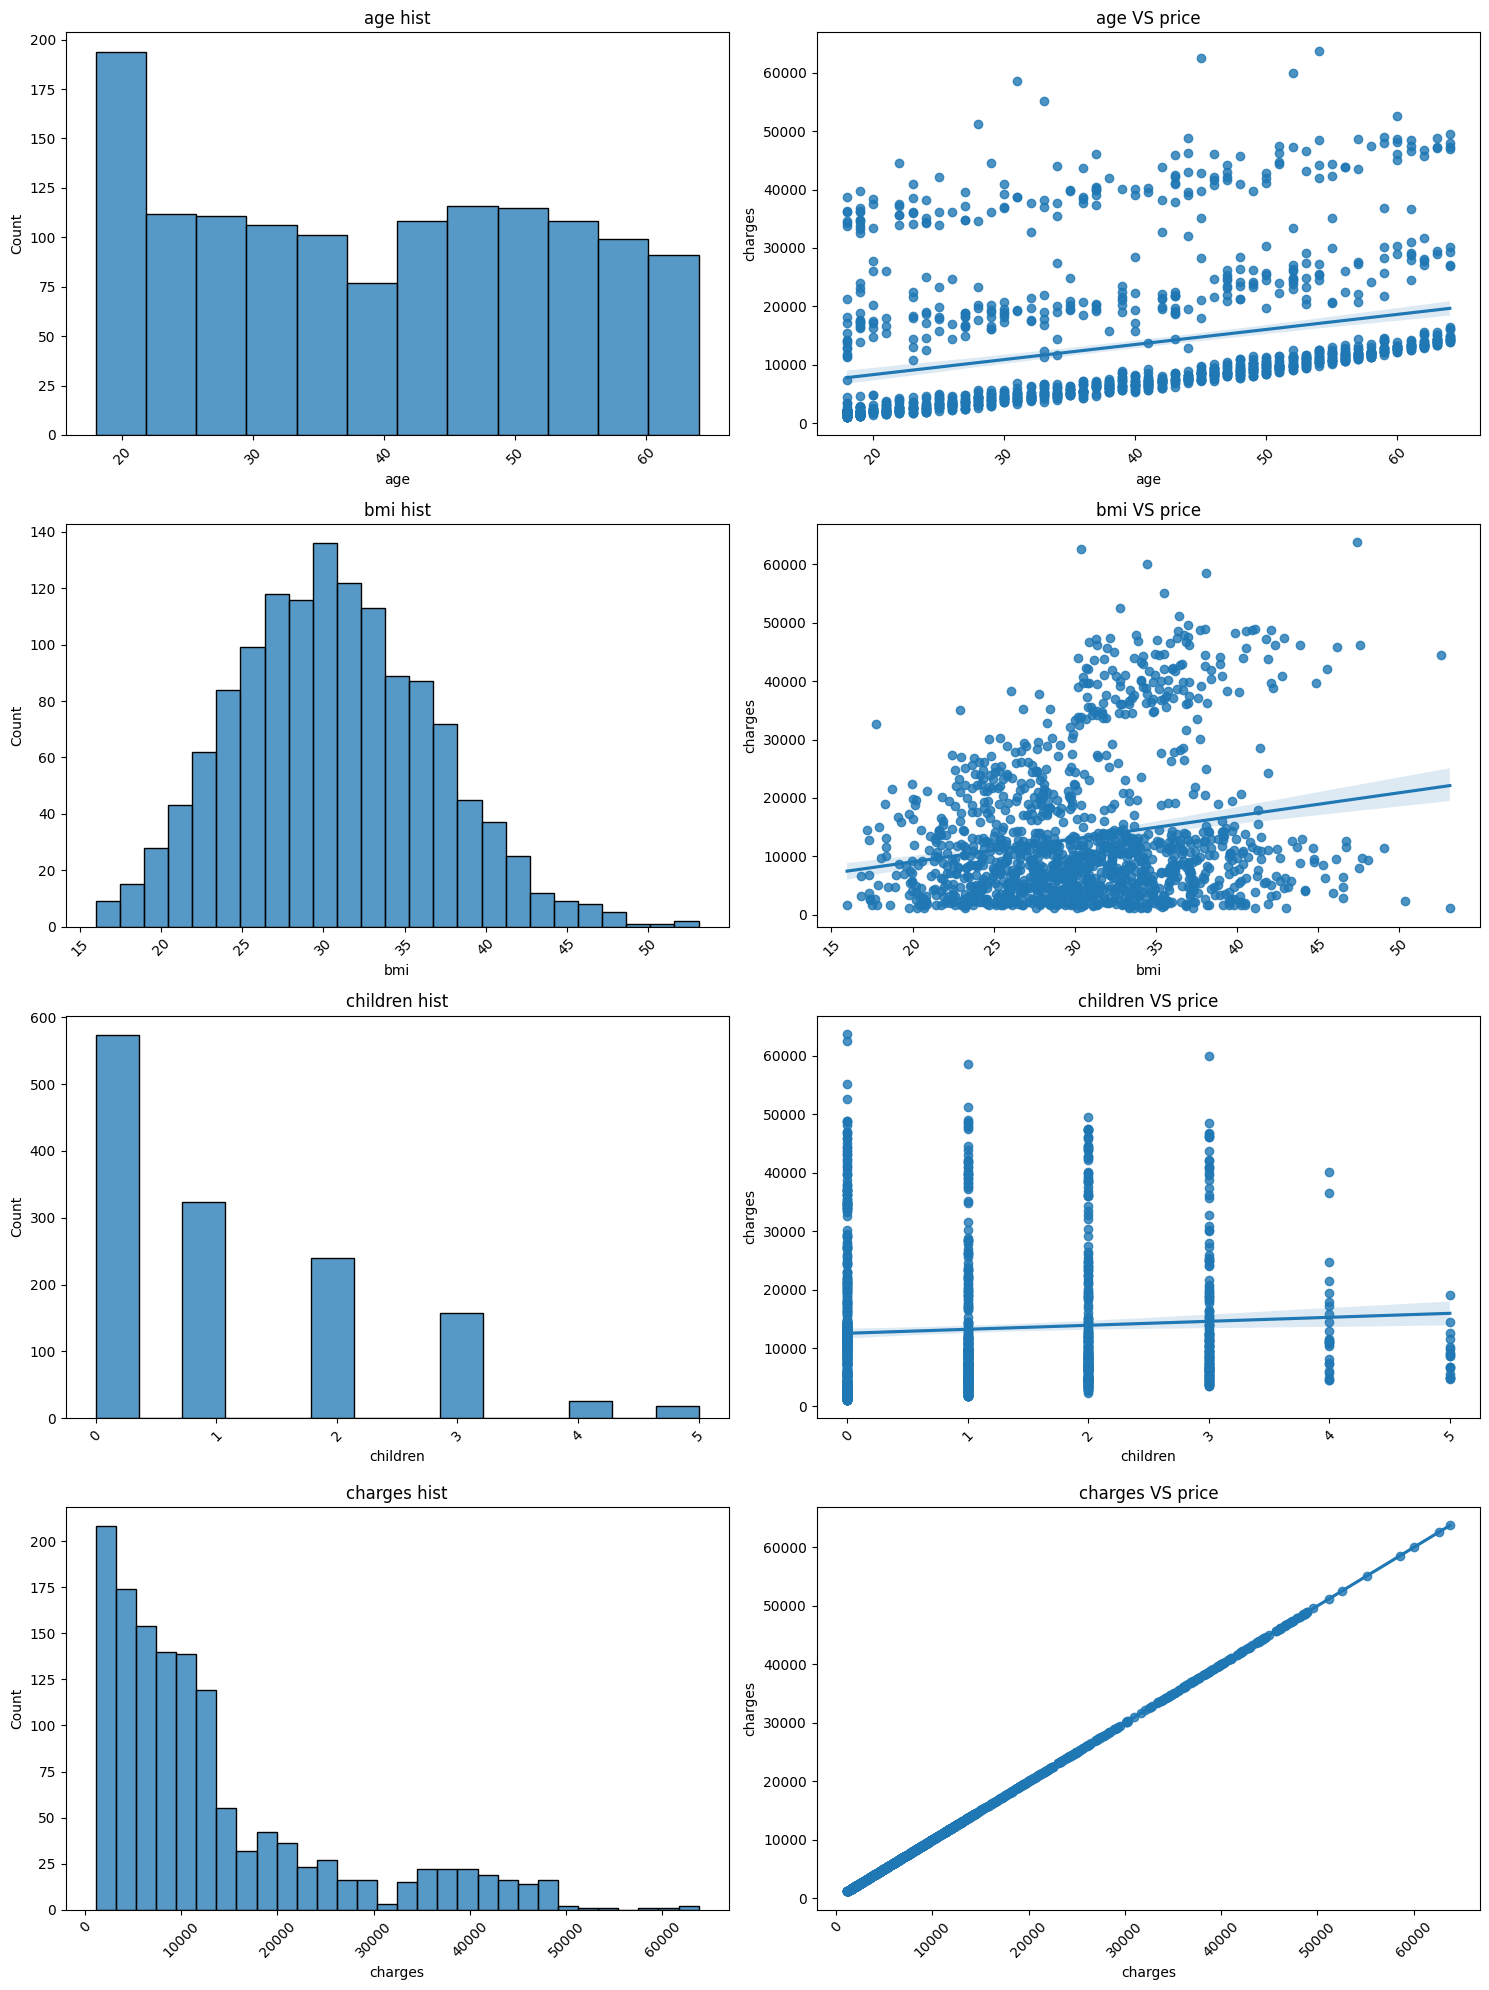

In [128]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [129]:
grouped = data.groupby('sex', as_index=False).agg(mean_score=('charges', 'mean'))
display(grouped)
# посмотрим какое было количество расходов в зависимости от пола
#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='sex', #ось x
    y='mean_score', #ось y
    color='sex', #расцветка в зависимости от страны
    text = 'mean_score', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Распределение расходов в зависимости от пола' #заголовок
)
#отображаем его
fig.show()


,sex,mean_score
0,female,12569.578844
1,male,13956.751178


In [130]:
grouped = data.groupby('smoker', as_index=False).agg(mean_score=('charges', 'mean'))
display(grouped)
# посмотрим какое было количество расходов в зависимости от того, курит человек или нет
#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='smoker', #ось x
    y='mean_score', #ось y
    color='smoker', #расцветка в зависимости от категории 
    text = 'mean_score', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Распределение расходов в зависимости от того, курит человек или нет' #заголовок
)
#отображаем его
fig.show()

,smoker,mean_score
0,no,8434.268298
1,yes,32050.231832


In [131]:
grouped = data.groupby('region', as_index=False).agg(mean_score=('charges', 'mean'))
display(grouped)
# посмотрим какое было количество расходов в зависимости от региона 
#строим график
fig = px.bar(
    data_frame=grouped, #датафрейм
    x='region', #ось x
    y='mean_score', #ось y
    color='region', #расцветка в зависимости от категории 
    text = 'mean_score', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Распределение расходов в зависимости от региона' #заголовок
)
#отображаем его
fig.show()

,region,mean_score
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

# Подготовка данных
Кодирование

In [132]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest' ]] = 
# = data[['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest' ]].apply(lambda x: x.astype(int))
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [133]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [134]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


Линейная регрессия

In [153]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)

print(np.round(lr_model.intercept_, 2))

y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)

-12390.8


In [151]:
# Создадим функцию, которая будет рассчитывать метрики
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

Линейная регрессия

In [154]:
#Выводим результирующие метрики
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


Посмотрим на разброс ошибок нашей модели с помощью boxplot-диграммы. 

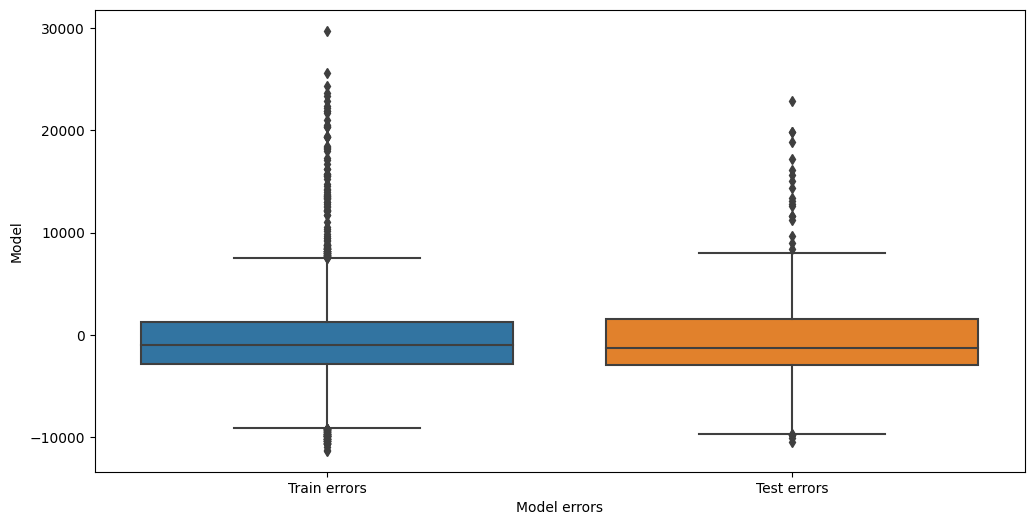

In [155]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_predict
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_predict
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

# Нормализация

In [139]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))


Train shape: (1070, 54)
Test shape: (268, 54)


Создание полиномиальных признаков

In [142]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)


Train R^2: 0.842
Train MAE: 2909.444
Train MAPE: 30.080


Test R^2: 0.866
Test MAE: 2761.826
Train MAPE: 31.149


In [146]:
print(lr_poly.coef_)

[-2.33744037e+16  1.80658975e+17  6.54572599e+15  8.19598379e+15
 -1.28411613e+16 -5.41525215e+16 -1.86801231e+17 -5.16951569e+16
 -2.99909056e+16  8.77600000e+03  9.56000000e+02  1.15200000e+03
 -1.67100000e+03  1.84000000e+02  2.33744037e+16  2.33744037e+16
  2.33744037e+16  2.33744037e+16 -1.34963978e+17  6.78625000e+02
 -1.23575000e+03  2.83625000e+02 -4.56949976e+16 -4.56949976e+16
 -4.56949976e+16 -4.56949976e+16 -9.71131250e+03  1.48968750e+03
  5.47753594e+04 -6.54572599e+15 -6.54572599e+15 -6.54572599e+15
 -6.54572599e+15 -2.04800000e+03 -2.22600000e+03 -8.19598379e+15
 -8.19598379e+15 -8.19598379e+15 -8.19598379e+15 -5.85445639e+15
  1.86956176e+16  1.86956176e+16  1.86956176e+16  1.86956176e+16
 -2.50483735e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.07600336e+17  0.00000000e+00  0.00000000e+00 -2.75057381e+16
  0.00000000e+00 -4.92099894e+16]


# Регуляризация

L-1 регуляризация

In [149]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


L-2 регуляризация

In [150]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель 
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)


Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
